In [2]:
from plantcv import plantcv as pcv
from pathlib import Path

from leafy.loader import ImageLoader

data_folder = Path("./images")
loader = ImageLoader(data_folder)    

# Colors

In [18]:
from torchvision.transforms.functional import to_tensor, to_pil_image
from leafy.types import rgb_image, mask, rgb_image_cv

import random
from PIL import Image

index = random.randint(0, len(loader) - 1)
im, y = loader[index]
im_path = loader.image_files[index]
img, path, filename = pcv.readimage(filename=str(im_path))

#Threshold your image by choosing points in the plot that will separate the green plant pixels from everything else. 
# It will draw a line between your two points and take every pixel "above" (if set to true). Do you get all of the plant?

# thresh1 = pcv.threshold.dual_channels(rgb_img = img, x_channel = "a", y_channel = "b", points = [(80,80),(125,140)], above=True)


# Image.fromarray(thresh1)

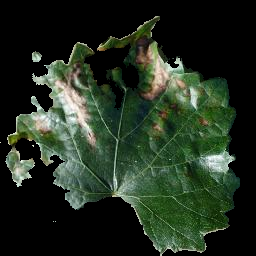

In [67]:
import numpy as np
from torch import Tensor
import torch

def tensor_to_cv(im: rgb_image) -> rgb_image_cv:
    # return (im.transpose(0, 1).transpose(1, 2) * 255).numpy().astype(np.uint8)
    return np.array(to_pil_image(im))[:,:,::-1]


def get_mask(im: rgb_image) -> mask:
    im_cv = tensor_to_cv(im)
    # im_last = im.transpose(0, 1).transpose(1, 2)
    thresh1 = pcv.threshold.dual_channels(rgb_img = im_cv, x_channel = "a", y_channel = "b", points = [(80,80),(125,140)], above=True)
    thresh1 = pcv.fill_holes(thresh1)
    return Tensor(thresh1 / 255.)

mask = get_mask(im)
to_pil_image(mask * im)

In [68]:
color_histogram = pcv.analyze.color(rgb_img=tensor_to_cv(im), labeled_mask=mask, colorspaces='all', label="default")
color_histogram

alt.FacetChart(...)

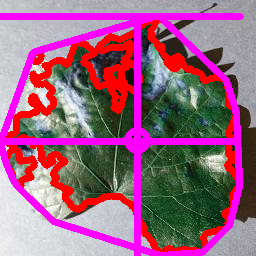

In [69]:
pcv.params.line_thickness = 5
shape_image = pcv.analyze.size(img=tensor_to_cv(im), labeled_mask=mask.to(torch.uint8).numpy() * 255, n_labels=1)
Image.fromarray(shape_image)

In [71]:
print(f"{tensor_to_cv(im).shape = } {img.shape = }")
print(f"{tensor_to_cv(im).max() = } {img.max() = }")
print(f"{tensor_to_cv(im).dtype = } {img.dtype = }")
print(f"{type(tensor_to_cv(im)) = } {type(img) = }")


tensor_to_cv(im).shape = (256, 256, 3) img.shape = (256, 256, 3)
tensor_to_cv(im).max() = 255 img.max() = 255
tensor_to_cv(im).dtype = dtype('uint8') img.dtype = dtype('uint8')
type(tensor_to_cv(im)) = <class 'numpy.ndarray'> type(img) = <class 'numpy.ndarray'>


array([[[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       ...,

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,

In [37]:
thresh1 = pcv.threshold.dual_channels(rgb_img = tensor_to_cv(im), x_channel = "a", y_channel = "b", points = [(80,80),(125,140)], above=True)

print(f"{mask.shape = } {thresh1.shape = }")
print(f"{mask.max() = } {thresh1.max() = }")
print(f"{mask.dtype = } {thresh1.dtype = }")

mask.shape = torch.Size([256, 256]) thresh1.shape = (256, 256)
mask.max() = tensor(1.) thresh1.max() = 255
mask.dtype = torch.float32 thresh1.dtype = dtype('uint8')


torch.Tensor